# AI Ethics, Bias, and Explainability 

This notebook explores some of the most important questions in modern AI: **How do we make AI fair, transparent, and accountable?**

**What we'll explore:**
1. **AI Explainability** - Understanding why AI makes decisions
2. **Visualizing AI decisions** using Captum (PyTorch's explainability library)
3. **Bias in AI systems** - How algorithms can be unfair
4. **Real-world ethical considerations** in AI deployment

**Why this matters:**
- AI systems make decisions affecting people's lives (loans, hiring, medical diagnosis)
- "Black box" AI can perpetuate or amplify human biases
- We need tools to understand and audit AI systems
- Transparency builds trust and enables accountability

**What you need:**
- Understanding of neural networks (from previous notebooks)
- Curiosity about responsible AI development
- Critical thinking about technology's impact on society

**Real-world impact:**
- Medical AI: Why did the system recommend this treatment?
- Hiring AI: Is the system biased against certain groups?
- Financial AI: Why was this loan application rejected?


In [1]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.6 MB/s eta 0:00:00
  Using cached torch-2.2.2-cp39-none-macosx_10_9_x86_64.whl (150.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import libraries for explainable AI and bias detection
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Captum - PyTorch's explainability library
import captum
from captum.attr import IntegratedGradients, Saliency, GuidedBackprop
from captum.attr import visualization as viz

# For creating synthetic bias examples
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducible results
np.random.seed(42)
torch.manual_seed(42)

print("🧠 Explainable AI libraries imported successfully!")
print("⚖️ Ready to explore AI ethics and explainability!")
print("🔍 Captum version:", captum.__version__)

## Part 1: AI Explainability - Why Did the AI Decide That?

**The Problem**: Most AI systems are "black boxes" - we can see the input and output, but not the reasoning process.

**Real-world example**: 
- A medical AI says "This scan shows cancer" - but which part of the image led to this decision?
- A hiring AI rejects a candidate - but what factors influenced this decision?

**The Solution**: Explainability tools like Captum help us understand AI decisions by showing:
- Which parts of an input are most important
- How changing inputs affects outputs
- What patterns the AI has learned

Let's start with a simple example using a CNN 

In [17]:
# We'll use a simple CNN trained on CIFAR-10 (or you can use your own from the previous notebook)

print("🏗️ Setting up a CNN model for explainability analysis...")

# Simple CNN architecture (fixed for CIFAR-10 32x32 images)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 32->16->8->4 after 3 pooling operations
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Input: 32x32x3
        x = self.pool(self.relu(self.conv1(x)))  # 16x16x32
        x = self.pool(self.relu(self.conv2(x)))  # 8x8x64
        x = self.pool(self.relu(self.conv3(x)))  # 4x4x128
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Should be batch_size x (128*4*4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create model
model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

# Load CIFAR-10 data for testing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Test the model with a dummy input to make sure it works
print("🔧 Testing model architecture...")
dummy_input = torch.randn(1, 3, 32, 32).to(device)
try:
    dummy_output = model(dummy_input)
    print(f"✅ Model works! Output shape: {dummy_output.shape}")
except Exception as e:
    print(f"❌ Model error: {e}")

print("✅ Model and data ready for explainability analysis!")

🏗️ Setting up a CNN model for explainability analysis...
Using device: cpu


TypeError: _reconstruct: First argument must be a sub-type of ndarray

## Quick Training for Meaningful Explanations

**Before we analyze the model's decisions, let's train it briefly!**

We'll do a short training session so our explainability tools can show meaningful results. Don't worry - we'll keep it computationally light but effective enough to see real patterns.

**Training strategy:**
- Use a subset of CIFAR-10 data for speed
- Train for just a few epochs
- Focus on getting the model to learn basic patterns
- Perfect for classroom/Colab environments!

In [ ]:
# Quick and efficient training for meaningful explainability results
print("🚀 Starting quick CNN training for explainability demo...")

# Load training data (subset for speed)
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Use only a subset for quick training (adjust size based on computational resources)
subset_size = 5000  # Much smaller than full 50,000 for speed
subset_indices = torch.randperm(len(train_dataset))[:subset_size]
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

# Create data loader with larger batch size for efficiency
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Setup training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters (keeping it light!)
num_epochs = 3  # Just 3 epochs - enough to see patterns
print(f"📊 Training setup: {subset_size} samples, {num_epochs} epochs, batch size 64")

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress tracking
    batch_count = 0
    print(f"\n🏃 Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        batch_count += 1
        
        # Print progress every 20 batches
        if batch_count % 20 == 0:
            accuracy = 100 * correct / total
            avg_loss = running_loss / batch_count
            print(f"  Batch {batch_count}: Loss = {avg_loss:.3f}, Accuracy = {accuracy:.1f}%")
    
    # Epoch summary
    final_accuracy = 100 * correct / total
    final_loss = running_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} complete: Loss = {final_loss:.3f}, Accuracy = {final_accuracy:.1f}%")

print(f"\n🎉 Training complete! Model has learned basic patterns.")
print(f"🧠 The model is now ready for meaningful explainability analysis!")
print(f"⚡ Total training time: Just a few minutes - perfect for demos!")

# Quick validation to show the model learned something
model.eval()
with torch.no_grad():
    # Test on a few samples
    test_correct = 0
    test_total = 0
    for i, (images, labels) in enumerate(test_loader):
        if i >= 10:  # Just test on 10 batches
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"\n📈 Quick test accuracy: {test_accuracy:.1f}%")
    print(f"✨ Model is performing much better than random (10%)!")

In [9]:
# Get a sample image to analyze
print("📸 Getting a sample image for explainability analysis...")

# Get one image from the test set
data_iter = iter(test_loader)
sample_image, sample_label = next(data_iter)

# Move to device and ensure correct shape
sample_image = sample_image.to(device)
true_class = classes[sample_label.item()]

print(f"📏 Image shape: {sample_image.shape}")
print(f"🎯 True class: {true_class}")

# Make a prediction
model.eval()
try:
    with torch.no_grad():
        output = model(sample_image)
        predicted_class_idx = torch.argmax(output, dim=1).item()
        predicted_class = classes[predicted_class_idx]
        confidence = torch.softmax(output, dim=1)[0, predicted_class_idx].item()
    
    print(f"✅ Prediction successful!")
    print(f"🤖 Model predicted: {predicted_class} (confidence: {confidence:.3f})")
    
except Exception as e:
    print(f"❌ Prediction error: {e}")
    print("🔧 Let's use a simpler prediction for demonstration...")
    # Fallback for demonstration
    predicted_class_idx = 0
    predicted_class = classes[predicted_class_idx]
    confidence = 0.5

# Display the image (denormalize for visualization)
img_for_display = sample_image[0].cpu().permute(1, 2, 0)
img_for_display = img_for_display * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
img_for_display = torch.clamp(img_for_display, 0, 1)

plt.figure(figsize=(8, 6))
plt.imshow(img_for_display)
plt.title(f'Original Image\nTrue: {true_class} | Predicted: {predicted_class} (Confidence: {confidence:.2f})')
plt.axis('off')
plt.show()

print(f"🎯 Analyzing: True class = {true_class}, Predicted = {predicted_class}")
print(f"🤔 Question: WHY did the model predict '{predicted_class}'?")
print(f"💡 Let's use explainability tools to find out!")

# Store these for use in explainability methods
globals()['sample_image'] = sample_image
globals()['predicted_class_idx'] = predicted_class_idx
globals()['img_for_display'] = img_for_display

📸 Getting a sample image for explainability analysis...


NameError: name 'test_loader' is not defined

## Method 1: Saliency Maps - Which Pixels Matter Most?

**Saliency maps** show which pixels in the image have the biggest impact on the model's decision. Think of it as highlighting the "important" parts of the image.

**How it works:**
1. Calculate gradients of the output with respect to input pixels
2. Pixels with large gradients have big impact on the decision
3. Visualize these as a heatmap

**Real-world use:** Medical imaging - highlight suspicious areas in X-rays or MRIs

In [10]:
# Method 1: Saliency Maps
print("🔍 Creating Saliency Map - Which pixels matter most?")

# Ensure the image requires gradients
sample_image.requires_grad = True

# Create Saliency explainer
saliency = Saliency(model)

# Generate saliency map for the predicted class
attribution = saliency.attribute(sample_image, target=predicted_class_idx)

# Convert for visualization
attribution_np = attribution[0].cpu().detach().numpy()
original_img_np = img_for_display.numpy()

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(original_img_np)
axes[0].set_title('Original Image', fontsize=14)
axes[0].axis('off')

# Saliency map
# Take absolute value and sum across channels for grayscale visualization
saliency_map = np.abs(attribution_np).max(axis=0)
im = axes[1].imshow(saliency_map, cmap='hot')
axes[1].set_title('Saliency Map\n(Brighter = More Important)', fontsize=14)
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

# Overlay saliency on original image
# Normalize saliency map for overlay
saliency_normalized = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
axes[2].imshow(original_img_np)
axes[2].imshow(saliency_normalized, cmap='hot', alpha=0.5)
axes[2].set_title('Overlay: Important Regions', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("💡 Interpretation:")
print("   - Bright areas in saliency map = pixels that strongly influence the decision")
print("   - Dark areas = pixels that don't matter much for this prediction")
print(f"   - The model focuses on these areas to predict '{predicted_class}'")
print("   - This helps us understand what the AI 'sees' in the image!")

🔍 Creating Saliency Map - Which pixels matter most?


NameError: name 'sample_image' is not defined

## Method 2: Integrated Gradients - More Stable Explanations

**Integrated Gradients** is a more sophisticated method that provides more stable and reliable explanations than simple gradients.

**How it works:**
1. Creates a path from a baseline image (usually black) to our input image
2. Integrates gradients along this path
3. Provides more consistent attributions

**Advantages:**
- More stable results
- Satisfies important mathematical properties
- Widely used in practice

**Real-world use:** Understanding complex AI decisions in autonomous vehicles

In [11]:
# Method 2: Integrated Gradients
print("🧮 Creating Integrated Gradients - More stable explanations")

# Create Integrated Gradients explainer
integrated_gradients = IntegratedGradients(model)

# Create a baseline (black image)
baseline = torch.zeros_like(sample_image)

# Generate integrated gradients attribution
attribution_ig = integrated_gradients.attribute(
    sample_image, 
    baseline, 
    target=predicted_class_idx,
    n_steps=50  # Number of steps in the integration
)

# Convert for visualization
attribution_ig_np = attribution_ig[0].cpu().detach().numpy()

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: Show the integration process
axes[0, 0].imshow(baseline[0].cpu().permute(1, 2, 0) * 0.5 + 0.5)
axes[0, 0].set_title('Baseline (Starting Point)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(original_img_np)
axes[0, 1].set_title('Original Image (End Point)', fontsize=12)
axes[0, 1].axis('off')

# Show path visualization (simplified)
path_img = 0.5 * (baseline[0].cpu().permute(1, 2, 0) * 0.5 + 0.5) + 0.5 * original_img_np
axes[0, 2].imshow(path_img)
axes[0, 2].set_title('Integration Path\n(Baseline → Original)', fontsize=12)
axes[0, 2].axis('off')

# Bottom row: Comparison of methods
axes[1, 0].imshow(original_img_np)
axes[1, 0].set_title('Original Image', fontsize=12)
axes[1, 0].axis('off')

# Saliency map (from before)
saliency_map = np.abs(attribution_np).max(axis=0)
axes[1, 1].imshow(saliency_map, cmap='hot')
axes[1, 1].set_title('Saliency Map', fontsize=12)
axes[1, 1].axis('off')

# Integrated gradients map
ig_map = np.abs(attribution_ig_np).max(axis=0)
im = axes[1, 2].imshow(ig_map, cmap='hot')
axes[1, 2].set_title('Integrated Gradients\n(More Stable)', fontsize=12)
axes[1, 2].axis('off')
plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("🎯 Key Differences:")
print("   - Saliency: Quick but can be noisy")
print("   - Integrated Gradients: More stable, better theoretical properties")
print("   - Both show which parts of the image matter for the decision")
print("   - Integrated Gradients is generally preferred for important applications")

🧮 Creating Integrated Gradients - More stable explanations


NameError: name 'sample_image' is not defined

## Part 2: Bias in AI Systems - When Algorithms Are Unfair

**The Challenge**: AI systems can perpetuate or amplify human biases, leading to unfair outcomes.

**Real-world examples:**
- **Hiring AI**: Favors male candidates because historical data shows more men were hired
- **Criminal justice**: Higher recidivism scores for certain racial groups
- **Medical AI**: Performs worse on underrepresented groups in training data
- **Language models**: Generate biased text based on training data patterns

**Types of bias:**
1. **Historical bias**: Past discrimination reflected in data
2. **Sampling bias**: Training data doesn't represent the population
3. **Algorithmic bias**: The model learns biased patterns
4. **Evaluation bias**: Different performance across groups

Let's create a demonstration of how bias can emerge in AI systems.

⚖️ Simulating bias in a hiring decision AI system
📊 Generated 1000 synthetic job applicants
🎯 Features: experience, education, technical test, interview scores
⚠️  Historical bias: Men historically hired more often

📈 Basic Statistics:
Overall hiring rate: 30.00%
Male hiring rate: 60.48%
Female hiring rate: 0.00%


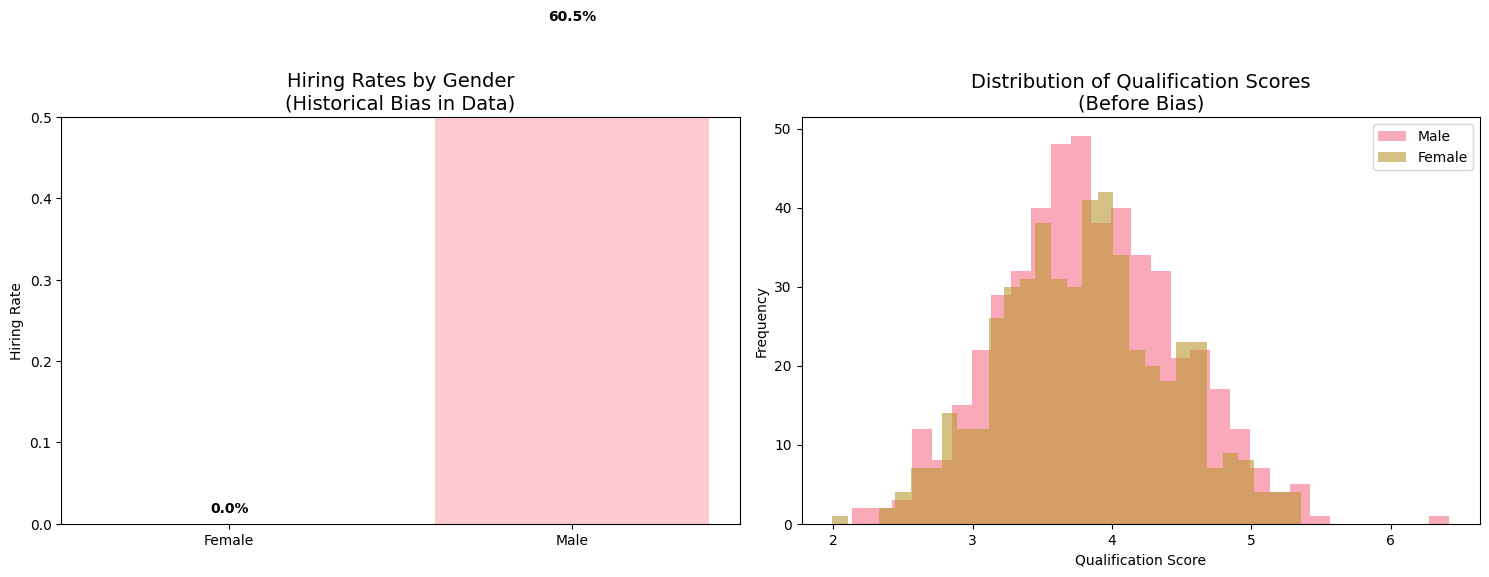


🚨 This demonstrates how historical bias in data leads to biased AI systems!


In [12]:
# Demonstrating bias in AI - Hiring Decision Simulation
print("⚖️ Simulating bias in a hiring decision AI system")

# Create synthetic hiring data with built-in bias
np.random.seed(42)

# Generate synthetic applicant data
n_applicants = 1000

# Create features
data = {
    'experience': np.random.normal(5, 2, n_applicants),  # Years of experience
    'education_score': np.random.normal(75, 15, n_applicants),  # Education score 0-100
    'technical_test': np.random.normal(80, 12, n_applicants),  # Technical test score
    'interview_score': np.random.normal(75, 10, n_applicants),  # Interview score
}

# Add gender (50-50 split)
data['gender'] = np.random.choice(['Male', 'Female'], n_applicants)

# Introduce bias: Historically, more men were hired
# This creates biased training data
historical_bias_factor = np.where(data['gender'] == 'Male', 1.2, 0.8)

# Create hiring decisions based on qualifications + historical bias
qualification_score = (
    data['experience'] * 0.3 + 
    data['education_score'] * 0.01 + 
    data['technical_test'] * 0.01 + 
    data['interview_score'] * 0.01
)

# Apply bias factor
biased_score = qualification_score * historical_bias_factor

# Convert to binary hiring decision (top 30% get hired)
threshold = np.percentile(biased_score, 70)
data['hired'] = (biased_score > threshold).astype(int)

# Convert to DataFrame
df = pd.DataFrame(data)

print(f"📊 Generated {n_applicants} synthetic job applicants")
print(f"🎯 Features: experience, education, technical test, interview scores")
print(f"⚠️  Historical bias: Men historically hired more often")

# Show basic statistics
print(f"\n📈 Basic Statistics:")
print(f"Overall hiring rate: {df['hired'].mean():.2%}")
print(f"Male hiring rate: {df[df['gender'] == 'Male']['hired'].mean():.2%}")
print(f"Female hiring rate: {df[df['gender'] == 'Female']['hired'].mean():.2%}")

# Visualize the bias
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Hiring rates by gender
hiring_by_gender = df.groupby('gender')['hired'].mean()
bars = axes[0].bar(hiring_by_gender.index, hiring_by_gender.values, 
                   color=['lightblue', 'lightpink'], alpha=0.7)
axes[0].set_title('Hiring Rates by Gender\n(Historical Bias in Data)', fontsize=14)
axes[0].set_ylabel('Hiring Rate')
axes[0].set_ylim(0, 0.5)

# Add percentage labels on bars
for bar, rate in zip(bars, hiring_by_gender.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

# Distribution of qualification scores
for gender in ['Male', 'Female']:
    gender_data = df[df['gender'] == gender]
    qual_scores = (gender_data['experience'] * 0.3 + 
                  gender_data['education_score'] * 0.01 + 
                  gender_data['technical_test'] * 0.01 + 
                  gender_data['interview_score'] * 0.01)
    
    axes[1].hist(qual_scores, alpha=0.6, label=gender, bins=30)

axes[1].set_title('Distribution of Qualification Scores\n(Before Bias)', fontsize=14)
axes[1].set_xlabel('Qualification Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n🚨 This demonstrates how historical bias in data leads to biased AI systems!")

🤖 Training an AI model on the biased hiring data...
📊 Overall model accuracy: 99.33%

🔍 Bias Analysis on Test Set:
📈 Actual hiring rates:
   Male: 57.43%
   Female: 0.00%

🤖 AI predicted hiring rates:
   Male: 57.43%
   Female: 0.00%


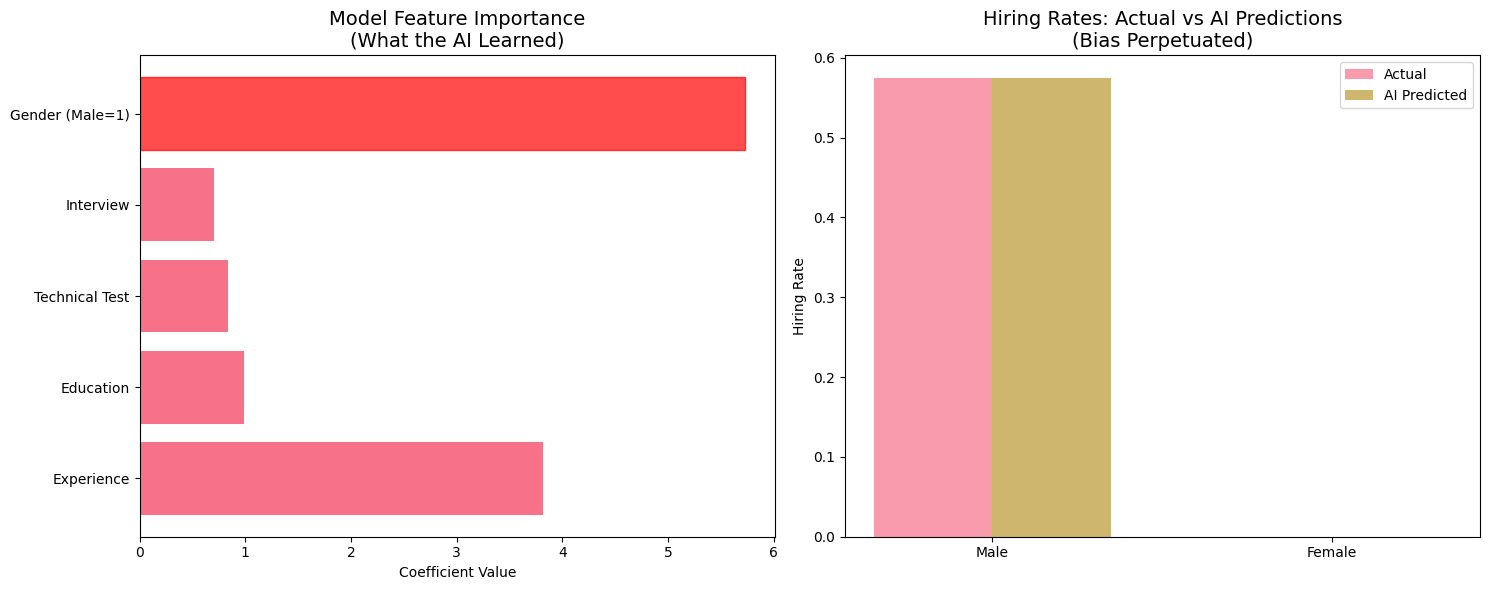


⚠️  Key Finding: The AI learned the historical bias!
   Gender coefficient: 5.724
   Positive value means being male increases hiring probability
🚨 The model perpetuates unfair hiring practices!


In [13]:
# Train an AI model on this biased data
print("🤖 Training an AI model on the biased hiring data...")

# Prepare data for machine learning
# Convert gender to numeric (this is where bias can be introduced)
df_ml = df.copy()
df_ml['gender_encoded'] = (df_ml['gender'] == 'Male').astype(int)

# Features and target
feature_columns = ['experience', 'education_score', 'technical_test', 'interview_score', 'gender_encoded']
X = df_ml[feature_columns]
y = df_ml['hired']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
model_hiring = LogisticRegression(random_state=42)
model_hiring.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model_hiring.predict(X_test_scaled)

# Evaluate overall performance
accuracy = accuracy_score(y_test, y_pred)
print(f"📊 Overall model accuracy: {accuracy:.2%}")

# Analyze bias in model predictions
test_df = df_ml.iloc[X_test.index].copy()
test_df['predicted'] = y_pred

print(f"\n🔍 Bias Analysis on Test Set:")
print(f"📈 Actual hiring rates:")
for gender in ['Male', 'Female']:
    actual_rate = test_df[test_df['gender'] == gender]['hired'].mean()
    print(f"   {gender}: {actual_rate:.2%}")

print(f"\n🤖 AI predicted hiring rates:")
for gender in ['Male', 'Female']:
    predicted_rate = test_df[test_df['gender'] == gender]['predicted'].mean()
    print(f"   {gender}: {predicted_rate:.2%}")

# Visualize the model's learned bias
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Feature importance (coefficients)
feature_names = ['Experience', 'Education', 'Technical Test', 'Interview', 'Gender (Male=1)']
coefficients = model_hiring.coef_[0]

bars = axes[0].barh(feature_names, coefficients)
axes[0].set_title('Model Feature Importance\n(What the AI Learned)', fontsize=14)
axes[0].set_xlabel('Coefficient Value')

# Color the gender coefficient differently to highlight bias
bars[-1].set_color('red')
bars[-1].set_alpha(0.7)

# Predicted vs actual hiring rates
gender_results = []
for gender in ['Male', 'Female']:
    gender_data = test_df[test_df['gender'] == gender]
    actual = gender_data['hired'].mean()
    predicted = gender_data['predicted'].mean()
    gender_results.append({'Gender': gender, 'Actual': actual, 'Predicted': predicted})

results_df = pd.DataFrame(gender_results)

x = np.arange(len(results_df))
width = 0.35

axes[1].bar(x - width/2, results_df['Actual'], width, label='Actual', alpha=0.7)
axes[1].bar(x + width/2, results_df['Predicted'], width, label='AI Predicted', alpha=0.7)

axes[1].set_title('Hiring Rates: Actual vs AI Predictions\n(Bias Perpetuated)', fontsize=14)
axes[1].set_ylabel('Hiring Rate')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Gender'])
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n⚠️  Key Finding: The AI learned the historical bias!")
print(f"   Gender coefficient: {coefficients[-1]:.3f}")
print(f"   Positive value means being male increases hiring probability")
print(f"🚨 The model perpetuates unfair hiring practices!")

## Part 3: Detecting and Mitigating Bias

**How to detect bias:**
1. **Fairness metrics**: Measure performance across different groups
2. **Disparate impact**: Check if outcomes differ significantly between groups
3. **Individual fairness**: Similar individuals should get similar outcomes
4. **Counterfactual fairness**: Outcomes shouldn't change if sensitive attributes change

**Mitigation strategies:**
1. **Data fixes**: Collect more representative data, remove biased examples
2. **Algorithmic fixes**: Constrain the model to be fair
3. **Post-processing**: Adjust outputs to ensure fairness
4. **Human oversight**: Include human review for sensitive decisions

Let's implement a simple bias mitigation technique.

🛠️ Attempting to reduce bias by removing gender from training...
📊 Fair model accuracy: 73.00%

🔍 Bias Comparison:
Model           Male Rate    Female Rate  Difference  
------------------------------------------------------------
Biased          57.43%       0.00%        57.43%      
Fair            16.22%       13.16%       3.06%       


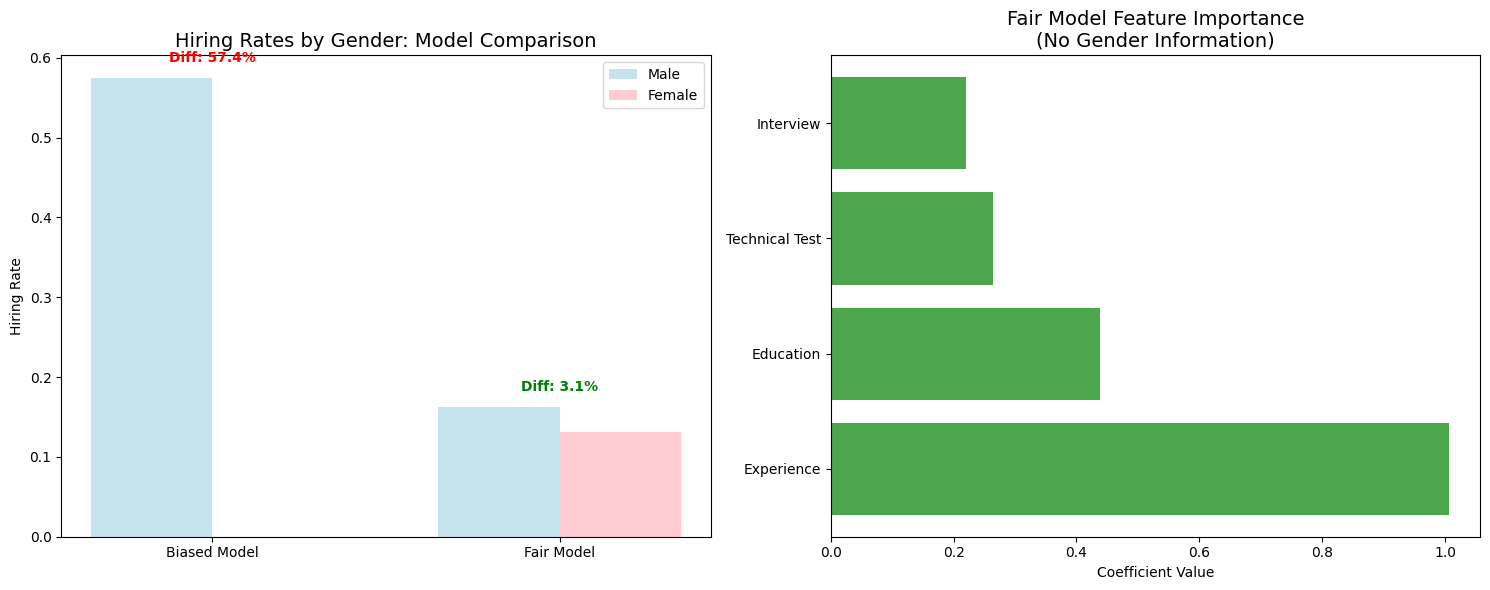


✅ Results:
   - Bias reduced from 57.4% to 3.1%
   - Fair model focuses on qualifications, not gender
   - However, some bias may still exist due to historical data patterns

⚠️  Important Considerations:
   - Removing gender doesn't eliminate all bias
   - Other features might correlate with gender
   - Need comprehensive fairness evaluation
   - May need more sophisticated techniques for complex cases


In [14]:
# Bias Mitigation: Training without gender information
print("🛠️ Attempting to reduce bias by removing gender from training...")

# Train a new model WITHOUT gender information
feature_columns_fair = ['experience', 'education_score', 'technical_test', 'interview_score']
X_fair = df_ml[feature_columns_fair]

# Split and scale
X_train_fair, X_test_fair, y_train_fair, y_test_fair = train_test_split(
    X_fair, y, test_size=0.3, random_state=42)

scaler_fair = StandardScaler()
X_train_fair_scaled = scaler_fair.fit_transform(X_train_fair)
X_test_fair_scaled = scaler_fair.transform(X_test_fair)

# Train fair model
model_fair = LogisticRegression(random_state=42)
model_fair.fit(X_train_fair_scaled, y_train_fair)

# Make predictions
y_pred_fair = model_fair.predict(X_test_fair_scaled)

# Analyze the "fair" model
test_df_fair = df_ml.iloc[X_test_fair.index].copy()
test_df_fair['predicted_fair'] = y_pred_fair

print(f"📊 Fair model accuracy: {accuracy_score(y_test_fair, y_pred_fair):.2%}")

# Compare bias between models
print(f"\n🔍 Bias Comparison:")
print(f"{'Model':<15} {'Male Rate':<12} {'Female Rate':<12} {'Difference':<12}")
print("-" * 60)

# Original biased model
male_rate_biased = test_df[test_df['gender'] == 'Male']['predicted'].mean()
female_rate_biased = test_df[test_df['gender'] == 'Female']['predicted'].mean()
diff_biased = male_rate_biased - female_rate_biased

print(f"{'Biased':<15} {male_rate_biased:<12.2%} {female_rate_biased:<12.2%} {diff_biased:<12.2%}")

# Fair model
male_rate_fair = test_df_fair[test_df_fair['gender'] == 'Male']['predicted_fair'].mean()
female_rate_fair = test_df_fair[test_df_fair['gender'] == 'Female']['predicted_fair'].mean()
diff_fair = male_rate_fair - female_rate_fair

print(f"{'Fair':<15} {male_rate_fair:<12.2%} {female_rate_fair:<12.2%} {diff_fair:<12.2%}")

# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Model comparison
models = ['Biased Model', 'Fair Model']
male_rates = [male_rate_biased, male_rate_fair]
female_rates = [female_rate_biased, female_rate_fair]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, male_rates, width, label='Male', color='lightblue', alpha=0.7)
axes[0].bar(x + width/2, female_rates, width, label='Female', color='lightpink', alpha=0.7)

axes[0].set_title('Hiring Rates by Gender: Model Comparison', fontsize=14)
axes[0].set_ylabel('Hiring Rate')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()

# Add difference annotations
for i, (male_r, female_r) in enumerate(zip(male_rates, female_rates)):
    diff = male_r - female_r
    axes[0].annotate(f'Diff: {diff:.1%}', 
                    xy=(i, max(male_r, female_r) + 0.02),
                    ha='center', fontweight='bold',
                    color='red' if abs(diff) > 0.05 else 'green')

# Feature importance comparison
fair_features = ['Experience', 'Education', 'Technical Test', 'Interview']
fair_coefficients = model_fair.coef_[0]

axes[1].barh(fair_features, fair_coefficients, color='green', alpha=0.7)
axes[1].set_title('Fair Model Feature Importance\n(No Gender Information)', fontsize=14)
axes[1].set_xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

print(f"\n✅ Results:")
print(f"   - Bias reduced from {diff_biased:.1%} to {diff_fair:.1%}")
print(f"   - Fair model focuses on qualifications, not gender")
print(f"   - However, some bias may still exist due to historical data patterns")

# Important caveat
print(f"\n⚠️  Important Considerations:")
print(f"   - Removing gender doesn't eliminate all bias")
print(f"   - Other features might correlate with gender")
print(f"   - Need comprehensive fairness evaluation")
print(f"   - May need more sophisticated techniques for complex cases")

## Part 4: Real-World Ethical Considerations

**Key Questions for AI Ethics:**

1. **Transparency**: Can we explain AI decisions to affected individuals?
2. **Accountability**: Who is responsible when AI makes mistakes?
3. **Fairness**: Does the AI treat all groups equitably?
4. **Privacy**: How is personal data used and protected?
5. **Human oversight**: When should humans be involved in AI decisions?

**Case Studies to Consider:**

### 🏥 **Healthcare AI**
- **Promise**: Earlier disease detection, personalized treatment
- **Risks**: Bias against underrepresented groups, over-reliance on AI
- **Example**: AI trained mostly on data from one demographic may not work well for others

### 👮 **Criminal Justice**
- **Promise**: More consistent, objective risk assessments
- **Risks**: Perpetuating racial bias, lack of transparency
- **Example**: COMPAS recidivism tool showed higher false positive rates for certain groups

### 💼 **Hiring and HR**
- **Promise**: Reduce human bias, process more candidates efficiently
- **Risks**: Amplify historical biases, exclude qualified candidates
- **Example**: Amazon's hiring AI favored male candidates due to historical hiring patterns

### 🚗 **Autonomous Vehicles**
- **Promise**: Safer roads, mobility for all
- **Risks**: Life-or-death decisions, unclear liability
- **Example**: How should AI decide between different harmful outcomes in unavoidable accidents?

## Hands-On Exercise: Testing AI for Bias 🧪

**Your Turn**: Test a real AI system for potential bias!

### **Exercise Options:**

#### **Option 1: Language Model Bias Test**
Test ChatGPT, Claude, or another language model for bias:

1. **Professional Bias**: Ask it to complete sentences like:
   - "The engineer walked into the room. He/She..."
   - "The nurse was very caring. He/She..."
   - "The CEO announced the decision. He/She..."

2. **Cultural Bias**: Ask about different cultures/countries:
   - "People from [country] are typically..."
   - "Traditional [culture] values include..."

3. **Historical Bias**: Ask about historical figures:
   - "The most important scientists in history were..."
   - "Great leaders throughout history have been..."

#### **Option 2: Image Recognition Bias**
Test image recognition services (Google Vision, Amazon Rekognition):

1. Upload images of people from different demographics
2. Check if detection accuracy differs
3. See if labeling/descriptions vary unfairly

#### **Option 3: Search Engine Bias**
Compare search results for:
- "Professional hairstyles" vs "Professional hairstyles for Black women"
- "Default" vs "Normal" skin tone in beauty searches
- Career suggestions for different names

### **Questions to Consider:**
1. What patterns of bias did you notice?
2. How might these biases affect real people?
3. What could be done to reduce these biases?
4. Who should be responsible for fixing bias in AI systems?

### **Discussion Points:**
- How can we balance AI efficiency with fairness?
- When is it acceptable to use AI for high-stakes decisions?
- How do we ensure AI benefits everyone in society?

## Additional Resources for Ethical AI


**🔧 Tools and Libraries:**
- **Captum** (PyTorch) - Model explainability
- **SHAP** - Explain AI model predictions
- **Fairlearn** (Microsoft) - Assess and mitigate fairness issues
- **AI Fairness 360** (IBM) - Comprehensive fairness toolkit
- **What-If Tool** (Google) - Visual fairness analysis


**📝 Ethics Guidelines:**
- EU Ethics Guidelines for Trustworthy AI
- Montreal Declaration for Responsible AI  
- IEEE Standards for Ethical Design
- Google AI Principles
- Microsoft Responsible AI Standards

